# Notebook objective
Explore the Home Credit Default Risk Kaggle dataset to understand the required data cleaning steps to predict defaulting customers.

https://www.kaggle.com/c/home-credit-default-risk/data

# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from zipfile import ZipFile
import matplotlib.image

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

In [3]:
# Create a function which can create a histogram, split by a variable
def plot_histogram_dv(x, y):
    plt.hist(list(x[y == 0]), alpha=0.5, label='DV=0')
    plt.hist(list(x[y == 1]), alpha=0.5, label='DV=1')
    plt.title("Histogram of '{var_name}' per category".format(var_name=x.name))
    plt.xlabel("Value")
    plt.xticks(rotation='vertical')
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')
    plt.show()

In [4]:
# Create a function which which creates a bar chart split by a variable
def plot_bar_dv(data):
    data.sort_values().plot(kind='bar')
    plt.title("Average repayment difficulty rate per category".format(var_name=data.name))
    plt.ylabel("AVG rayment difficulty (%)")
    plt.show()

In [5]:
# Create a function which which creates a bar chart split by a variable
def plot_bar_dv_unordered(data):
    data.plot(kind='bar')
    plt.title("Average repayment difficulty rate per category".format(var_name=data.name))
    plt.ylabel("AVG rayment difficulty (%)")
    plt.show()

In [6]:
# Create function which calculates the likelihood of customer payment difficulties
def payp_likelihood(var_name):
    count_groupby = test_df.groupby(var_name)['TARGET'].sum()
    total_groupby = test_df.groupby(var_name)['TARGET'].count()
    return count_groupby / total_groupby

## Folder structure

In [7]:
# Make root folder the current working directory
os.chdir('..')

In [8]:
input_folder = './data/raw/'

In [9]:
output_folder = './reports/figures/'

## Data overview

### application_{train|test}.csv
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

### bureau.csv
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### bureau_balance.csv
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e. the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

### POS_CASH_balance.csv
- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

### credit_card_balance.csv
- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

### previous_application.csv
- All previous applications for Home Credit loans of clients who have loans in our sample.
- There is one row for each previous application related to loans in our data sample.

### installments_payments.csv
- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one instalment OR one instalment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

### HomeCredit_columns_description.csv
- This file contains descriptions for the columns in the various data files.

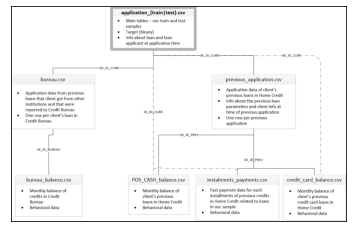

In [10]:
link = 'https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png'
read_img = matplotlib.image.imread(link)
plt.xticks([]), plt.yticks([])
plt.imshow(read_img)

## Import data

With the objective of creating a model that can be applied to the financially excluded, I deselected columns with data related to credit bureau, bank related data and formal loans.

The data dictionary can be found here:
https://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv

In [11]:
# Select columns which can be used by financially excluded
column_selection = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
                    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
                    'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
                    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                    'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
                    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
                    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                    'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                    'AMT_ANNUITY', 'AMT_GOODS_PRICE']

In [12]:
# Import the selected columns from the source data
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
application_train_df = pd.read_csv(zip_file.open('application_train.csv'), usecols=column_selection)

In [13]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
credit_card_df = pd.read_csv(zip_file.open('credit_card_balance.csv'), usecols=('SK_ID_CURR', 'NAME_CONTRACT_STATUS'))

In [14]:
zip_file = ZipFile(input_folder + 'home-credit-default-risk.zip')
bureau_df = pd.read_csv(zip_file.open('bureau.csv'), usecols=('SK_ID_CURR', 'CREDIT_ACTIVE'))

# Data exploration

## Data overview

In [15]:
application_train_df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,0,0,0,0,0,0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,0,0,0,0,0,0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,0,0,0,0,0,0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
application_train_df.shape

(307511, 113)

In [17]:
application_train_df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [18]:
# Count the number of columns available
len(application_train_df.columns)

113

In [19]:
# Add column for calculations
application_train_df['SUM'] = 1

### Missing data

In [20]:
test_df = application_train_df.copy()

<AxesSubplot:>

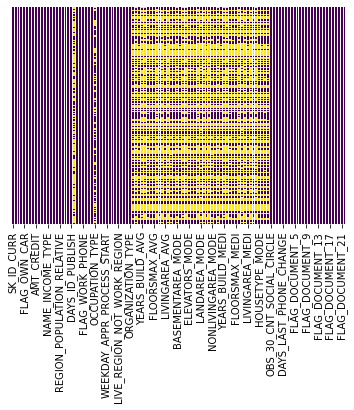

In [21]:
# Visualise missing data
sns.heatmap(test_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

The heatmap shows that quite some features have missing data. Next, we'll be looking for columns with a lot of missing data

In [22]:
# Calculate the missing data % in training data
missing_data = test_df.isna().sum() / test_df.isna().count() * 100
missing_data[missing_data > 0].sort_values(ascending=False)

COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
COMMONAREA_MEDI                 69.872297
NONLIVINGAPARTMENTS_AVG         69.432963
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_MEDI        69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_AVG            68.354953
FLOORSMIN_AVG                   67.848630
FLOORSMIN_MEDI                  67.848630
FLOORSMIN_MODE                  67.848630
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MODE                   59.376738
LANDAREA_MEDI                   59.376738
LANDAREA_AVG                    59.376738
BASEMENTAREA_MODE               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MEDI               58.515956
NONLIVINGAREA_MEDI              55

In [23]:
# Remove features with more than 50% missing data
missing_data[missing_data > 50].count()

features_40p_missing = list(missing_data[missing_data > 50].keys())
print('The following features have been dropped:', features_40p_missing)

test_df.drop(columns=features_40p_missing, inplace=True)
test_df = application_train_df.copy()

The following features have been dropped: ['OWN_CAR_AGE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [24]:
# Count the number of remaining features
len(test_df.columns)

114

In [25]:
# List available categorical values
list(test_df.select_dtypes(include=['object']))

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [26]:
# List available continuous variables
list(test_df.select_dtypes(include=['float64']))

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 

In [27]:
test_df.columns[test_df.isna().any()].tolist()

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 

<AxesSubplot:>

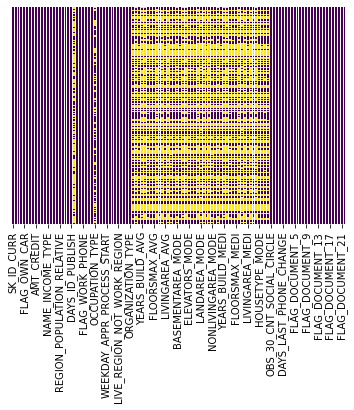

In [28]:
sns.heatmap(test_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Findings:
- To prevent overfitting, we'll remove features  with more than 40% missing data

In [29]:
test_df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,SUM
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.0
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,1.0
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.0
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


Because there are quite a number of datapoints, next we'll be reviewing the remaining data per data type:
- Categorical
- Continuous
- Ordinal

In [30]:
test_df.shape

(307511, 114)

### Dependent variable

In [31]:
test_df = application_train_df.copy()

In [32]:
test_df['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [33]:
# Calculate the % of missing data
variable = 'TARGET'
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

Findings:
- ~8% of customers have payment difficulties. This means that the dataset is highly unbalanced, which will affect the algorithms that can be applied or requires the dataset to be artificially balanced
- No missing data

### Identifying financially excluded

First step is to select unbanked customers to later evaluate that the ML model doesn't classify them as repayment risk. In the dataset there is no data available on whether the customer has a bank account, which is usually the first formal financial product people start using. Instead, we will be classifying someone as unbanked if there is no credit card or credit bureau information available.

With the objective of creating a model that can be applied to the financially excluded, I deselected columns with data related to credit bureau, bank related data and formal loans.

The data dictionary can be found here:
https://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv

In [34]:
# Select columns which can be used by financially excluded
column_selection = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
                    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
                    'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
                    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                    'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
                    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
                    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                    'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                    'AMT_ANNUITY', 'AMT_GOODS_PRICE']

In [35]:
# Find the IDs of the financially excluded
ID_fin_included_df = list(credit_card_df['SK_ID_CURR']) + list(bureau_df['SK_ID_CURR'])
ID_fin_included_df = list(dict.fromkeys(ID_fin_included_df))
ID_all_applicants = test_df['SK_ID_CURR']
ID_fin_excluded = list(set(list(ID_all_applicants)) - set(ID_fin_included_df))

In [36]:
variable = 'fin_excluded'

In [37]:
# Create binary values
test_df.loc[test_df['SK_ID_CURR'].isin(ID_fin_excluded), variable] = 1
test_df[variable].fillna(value=0, inplace=True)

In [38]:
# Variable distribution
test_df[variable].value_counts(normalize=True)

0.0    0.894853
1.0    0.105147
Name: fin_excluded, dtype: float64

In [39]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

fin_excluded
1.0    0.101534
0.0    0.078284
Name: TARGET, dtype: float64

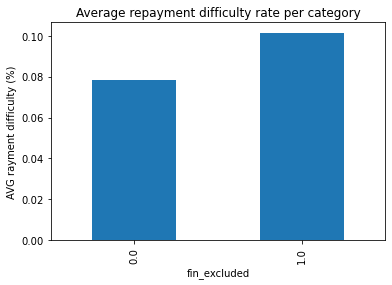

In [40]:
plot_bar_dv(payp_likelihood(variable))

In [41]:
# Remove column to prevent skewing negatively towards the financially excluded
test_df.drop(columns='fin_excluded', inplace=True)

Findings
- Around 10% of loan applicants can be considered financially excluded based on credit card and credit bureau records
- Financially excluded customers are 29% more likely to experience payment difficulties

Next
- We won't be using this as a features, but will use it to evaluate if our final model provides loans for the financially excluded

### Check for duplicate customers

In [42]:
dup_check = test_df.duplicated(subset='SK_ID_CURR', keep=False)
test_df[dup_check]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,SUM


Findings:
- No duplicate customer entries in application dataset

In [43]:
test_df.shape

(307511, 114)

## Categorical variables

In [44]:
# List available categorical values
list(test_df.select_dtypes(include=['object']))

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

**Feature:  NAME_CONTRACT_TYPE**

In [45]:
variable = 'NAME_CONTRACT_TYPE'

In [46]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [47]:
# Look at available contract types
test_df[variable].value_counts(normalize=True)

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64

In [48]:
# Calculate likelihood of repayment difficulties
x_percent = payp_likelihood(variable)
x_percent

NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
Name: TARGET, dtype: float64

In [49]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

NAME_CONTRACT_TYPE
Cash loans         0.083459
Revolving loans    0.054783
Name: TARGET, dtype: float64

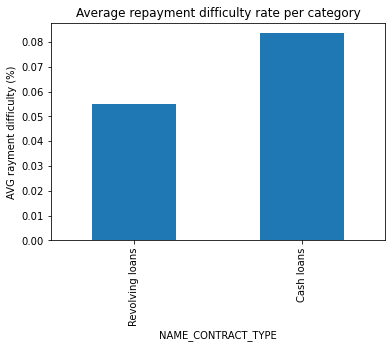

In [50]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- ~90% of customers applied for a cash loan
- Cash loan customers are more likely to experience payment difficulties than customers with revolving loans

**Feature: CODE_GENDER**

In [51]:
test_df = application_train_df.copy()

In [52]:
variable = 'CODE_GENDER'

In [53]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [54]:
# Look at available contract types
test_df[variable].value_counts(normalize=True)

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

In [55]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

CODE_GENDER
M      0.101419
F      0.069993
XNA    0.000000
Name: TARGET, dtype: float64

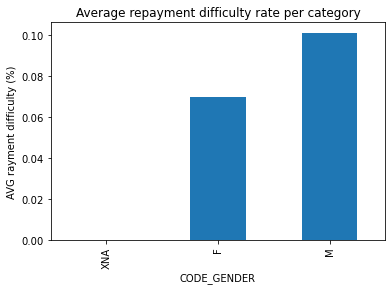

In [56]:
plot_bar_dv(payp_likelihood(variable))

In [57]:
# Replace 'XNA' with the most frequent occurring gender response
freq = test_df['CODE_GENDER'].value_counts().index.tolist()[0]
test_df['CODE_GENDER'].replace('XNA', freq, inplace=True)

Findings
- ~65% of customers are female
- Men are  more likely to experience payment difficulties
- Only 0.000013 of customers didn't provide their gender ('XNA') so it may be good to recode this to the most frequently occurring one ('F')

**Feature:  FLAG_OWN_CAR**

In [58]:
variable = 'FLAG_OWN_CAR'

In [59]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [60]:
# Look at available contract types
test_df[variable].value_counts(normalize=True)

N    0.659892
Y    0.340108
Name: FLAG_OWN_CAR, dtype: float64

In [61]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

FLAG_OWN_CAR
N    0.085002
Y    0.072437
Name: TARGET, dtype: float64

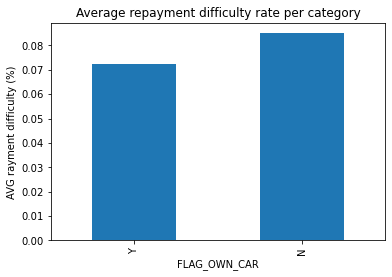

In [62]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- ~65% of customers doesn't own a car
- Customers without a car are slightly more likely to experience payment difficulties

**Feature: FLAG_OWN_REALTY**

In [63]:
variable = 'FLAG_OWN_REALTY'

In [64]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [65]:
# Look at available contract types
test_df[variable].value_counts(normalize=True)

Y    0.693673
N    0.306327
Name: FLAG_OWN_REALTY, dtype: float64

In [66]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

FLAG_OWN_REALTY
N    0.083249
Y    0.079616
Name: TARGET, dtype: float64

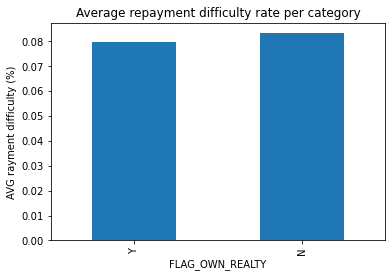

In [67]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- ~69% of customers owns their own property
- Customers without an own house are slightly more likely to experience payment difficulties, but the difference is minimal

**Feature:   NAME_TYPE_SUITE**

In [68]:
variable = 'NAME_TYPE_SUITE'

In [69]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.42014757195677555

In [70]:
# Look at availabletypes
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

Unaccompanied      0.808186
Family             0.130561
Spouse, partner    0.036974
Children           0.010624
Other_B            0.005756
NaN                0.004201
Other_A            0.002816
Group of people    0.000881
Name: NAME_TYPE_SUITE, dtype: float64

In [71]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

NAME_TYPE_SUITE
Other_B            0.098305
Other_A            0.087760
Group of people    0.084871
Unaccompanied      0.081830
Spouse, partner    0.078716
Family             0.074946
Children           0.073768
Name: TARGET, dtype: float64

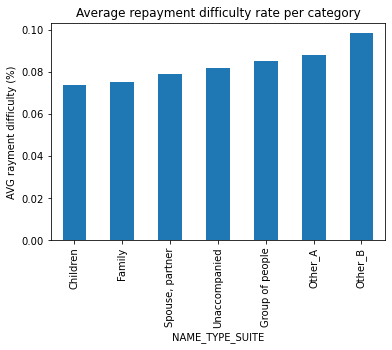

In [72]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- The majority (~81%) of customers applied indvidually for a loan
- Categories of less than <1% should be removed to prevent overfitting (Group of people, other_a, other_b)
- Between unaccompaniedapplicants and family (majority of customers), unaccompanied customers are almost 1% more likely to have payment issues

**Feature: NAME_INCOME_TYPE**

In [73]:
test_df = application_train_df.copy()

In [74]:
variable = 'NAME_INCOME_TYPE'

In [75]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [76]:
# Look at available types
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman             0.000033
Maternity leave         0.000016
Name: NAME_INCOME_TYPE, dtype: float64

In [77]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

NAME_INCOME_TYPE
Maternity leave         0.400000
Unemployed              0.363636
Working                 0.095885
Commercial associate    0.074843
State servant           0.057550
Pensioner               0.053864
Student                 0.000000
Businessman             0.000000
Name: TARGET, dtype: float64

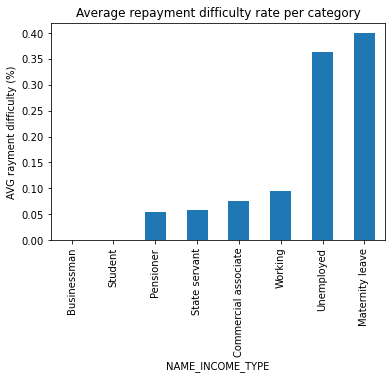

In [78]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- The majority of customers either receive income from work, commercial associate or pensioner
- Of those categories, workers are most likely to experience payment difficulties. This is
- Low frequently occuring income types are better to be excluded to prevent an unequal negative impact resulting from limited data availability (i.e. Unemployed, Student, Businessman, Maternity leave)

**Feature:   NAME_EDUCATION_TYPE**

In [79]:
test_df = application_train_df.copy()

In [80]:
variable = 'NAME_EDUCATION_TYPE'

In [81]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [82]:
# Look at availabletypes
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

Secondary / secondary special    0.710189
Higher education                 0.243448
Incomplete higher                0.033420
Lower secondary                  0.012409
Academic degree                  0.000533
Name: NAME_EDUCATION_TYPE, dtype: float64

In [83]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

NAME_EDUCATION_TYPE
Lower secondary                  0.109277
Secondary / secondary special    0.089399
Incomplete higher                0.084850
Higher education                 0.053551
Academic degree                  0.018293
Name: TARGET, dtype: float64

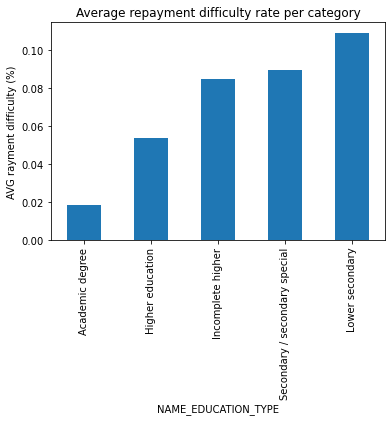

In [84]:
plot_bar_dv(payp_likelihood(variable))

Conclusion
- No missing data
- Most customers highest degree is  secondary education (71%), followed by higher education (24%)
- Of those two categories, customers with higher education are less likely to experience payment difficulties (5.3% vs 8.9%) 

**Feature: NAME_FAMILY_STATUS**

In [85]:
test_df = application_train_df.copy()

In [86]:
variable = 'NAME_FAMILY_STATUS'

In [87]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [88]:
# Look at availabletypes
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

Married                 0.638780
Single / not married    0.147780
Civil marriage          0.096826
Separated               0.064290
Widow                   0.052317
Unknown                 0.000007
Name: NAME_FAMILY_STATUS, dtype: float64

In [89]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

NAME_FAMILY_STATUS
Civil marriage          0.099446
Single / not married    0.098077
Separated               0.081942
Married                 0.075599
Widow                   0.058242
Unknown                 0.000000
Name: TARGET, dtype: float64

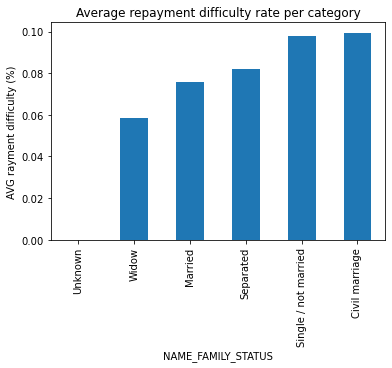

In [90]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- 0.000007 missing data ('unknown')
- Most customers are married (64%), followed by single (15%)
- Single customers or customers with a civil marriage are most likely to experience payment difficulties

**Feature: NAME_HOUSING_TYPE**

In [91]:
variable = 'NAME_HOUSING_TYPE'

In [92]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [93]:
# Look at availabletypes
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

House / apartment      0.887344
With parents           0.048258
Municipal apartment    0.036366
Rented apartment       0.015873
Office apartment       0.008510
Co-op apartment        0.003649
Name: NAME_HOUSING_TYPE, dtype: float64

In [94]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

NAME_HOUSING_TYPE
Rented apartment       0.123131
With parents           0.116981
Municipal apartment    0.085397
Co-op apartment        0.079323
House / apartment      0.077957
Office apartment       0.065724
Name: TARGET, dtype: float64

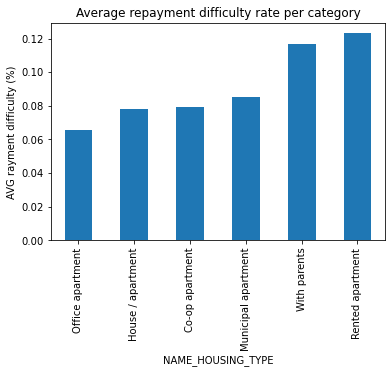

In [95]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- The majority of customer live in a house or apartment (89%), followed by living with parents (5%) and municipal apartment (4%)
- Of those three groups, customers living with parents are most likely to experience payment difficulties

**Feature:  WEEKDAY_APPR_PROCESS_START**

In [96]:
test_df = application_train_df.copy()

In [97]:
variable = 'WEEKDAY_APPR_PROCESS_START'

In [98]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [99]:
# Look at availabletypes
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

TUESDAY      0.175282
WEDNESDAY    0.168885
MONDAY       0.164918
THURSDAY     0.164518
FRIDAY       0.163695
SATURDAY     0.110084
SUNDAY       0.052619
Name: WEEKDAY_APPR_PROCESS_START, dtype: float64

In [100]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

WEEKDAY_APPR_PROCESS_START
TUESDAY      0.083505
WEDNESDAY    0.081604
FRIDAY       0.081469
THURSDAY     0.081003
SUNDAY       0.079291
SATURDAY     0.078873
MONDAY       0.077572
Name: TARGET, dtype: float64

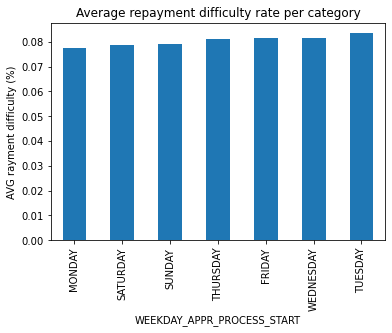

In [101]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- Previous application days of customers are fairly equally distributed during weekdays (~16%), with slightly less applications on Saturday (11%) and even some on Sunday (5%)
- There isn't much variation on payment difficulties, so this feature is unlikely to be of use when building the model

**Feature:   ORGANIZATION_TYPE**

In [102]:
test_df = application_train_df.copy()

In [103]:
variable = 'ORGANIZATION_TYPE'

In [104]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

In [105]:
# Look at availabletypes
test_df[variable].value_counts(normalize=True, dropna=False).sort_values(ascending=False)

Business Entity Type 3    0.221104
XNA                       0.180072
Self-employed             0.124913
Other                     0.054252
Medicine                  0.036399
Business Entity Type 2    0.034317
Government                0.033833
School                    0.028919
Trade: type 7             0.025466
Kindergarten              0.022373
Construction              0.021856
Business Entity Type 1    0.019459
Transport: type 4         0.017554
Trade: type 3             0.011356
Industry: type 9          0.010952
Industry: type 3          0.010660
Security                  0.010559
Housing                   0.009619
Industry: type 11         0.008793
Military                  0.008566
Bank                      0.008153
Agriculture               0.007980
Police                    0.007613
Transport: type 2         0.007167
Postal                    0.007014
Security Ministries       0.006419
Trade: type 2             0.006179
Restaurant                0.005889
Services            

In [106]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

ORGANIZATION_TYPE
Transport: type 3         0.157540
Industry: type 13         0.134328
Industry: type 8          0.125000
Restaurant                0.117062
Construction              0.116798
Cleaning                  0.111538
Industry: type 1          0.110683
Industry: type 3          0.106162
Realtor                   0.106061
Agriculture               0.104727
Trade: type 3             0.103379
Self-employed             0.101739
Industry: type 4          0.101482
Security                  0.099784
Trade: type 7             0.094496
Business Entity Type 3    0.092996
Transport: type 4         0.092812
Mobile                    0.091483
Trade: type 1             0.089080
Industry: type 11         0.086538
Business Entity Type 2    0.085284
Postal                    0.084376
Advertising               0.081585
Business Entity Type 1    0.081384
Industry: type 7          0.080337
Housing                   0.079446
Legal Services            0.078689
Transport: type 2         0.078040
Ot

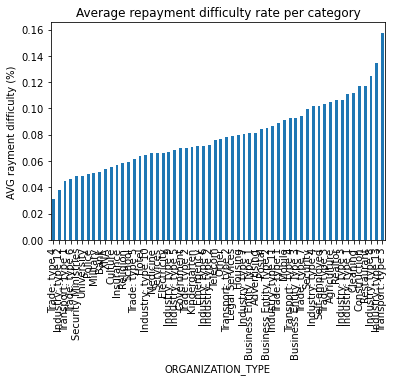

In [107]:
plot_bar_dv(payp_likelihood(variable))

Findings:
- No missing data
- Most frequent organisation where customers work: 
    - 22% Business Entity Type 3
    - 18% XNA
    - 12% Self-employed
- Less frequent types can likely be re-grouped to reduce outliers:
    - Transport = Transport: type 1+2+3
    - Trade = Transport: type 1+2+3+4+5+6+7
- Of those categories, self-employed has most likely payment difficulties, followed by Business entity Type 3
    -  9.3% Business Entity Type 3
    -  5.4% XNA
    - 10.2% Self-employed

## Continuous variables

In [108]:
test_df = application_train_df.copy()

In [109]:
# List available continuous variables
list(test_df.select_dtypes(include=['float64']))

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 

**Feature:  AMT_INCOME_TOTAL**

In [110]:
variable = 'AMT_INCOME_TOTAL'

In [111]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

<AxesSubplot:title={'center':'AMT_INCOME_TOTAL'}, xlabel='TARGET'>

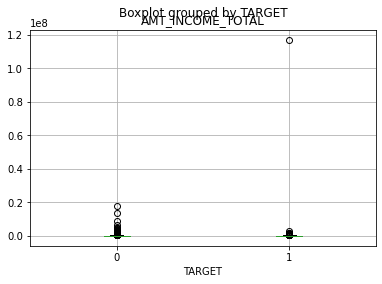

In [112]:
test_df.boxplot(column=variable, by='TARGET')

Clearly, one or more values are frequently occuring, creating a distorted graph

In [113]:
# Identify most frequently occurring value, which appears to distort graph
test_df[variable].value_counts().index.tolist()[0]

135000.0

In [114]:
# Count the number of customers with the most frequently occurring value
test_df[test_df[variable] == 135000]['SK_ID_CURR'].count() / test_df['SK_ID_CURR'].count()

0.11625600385026877

In [115]:
# Remove outliers
test_df = test_df[(np.abs(stats.zscore(test_df[variable])) < 2.5)]

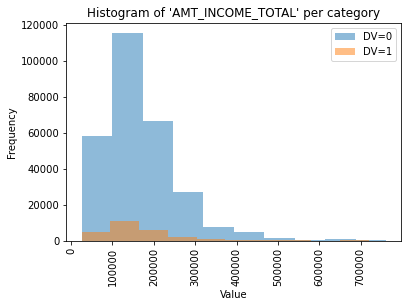

In [116]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable], test_df['TARGET'])

As the graph above shows, the data of this variable is skewed or not normalised. If this data is used in its current form, the final model could be skewed because its algorithm expects to receive only normalised data. A log transformation of that variable can resolve this. 

In [117]:
# Log transform the variable to normalise
test_df[variable + '_log'] = np.log(test_df[variable])

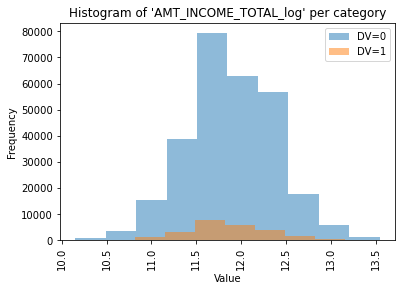

In [118]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable + '_log'], test_df['TARGET'])

In [119]:
# Create feature bins to evaluate payment issues trend
variable = 'AMT_INCOME_TOTAL_bin'
test_df[variable] = pd.cut(x=test_df['AMT_INCOME_TOTAL'], right=False, bins=15)
test_df[[variable, 'SUM', 'TARGET']].groupby(variable).sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
AMT_INCOME_TOTAL_bin,,,
"[25650.0, 74700.0)",23878,1869,0.078273
"[74700.0, 123750.0)",83401,7190,0.086210
"[123750.0, 172800.0)",82560,7029,0.085138
"[172800.0, 221850.0)",49815,4095,0.082204
"[221850.0, 270900.0)",40698,2975,0.073099
"[270900.0, 319950.0)",11017,717,0.065081
"[319950.0, 369000.0)",6682,392,0.058665
"[369000.0, 418050.0)",3167,204,0.064414
"[418050.0, 467100.0)",3187,185,0.058048


In [120]:
# Calculate repayment difficulties likelihood
payp_likelihood(variable).sort_values(ascending=False)

AMT_INCOME_TOTAL_bin
[74700.0, 123750.0)      0.086210
[123750.0, 172800.0)     0.085138
[172800.0, 221850.0)     0.082204
[25650.0, 74700.0)       0.078273
[221850.0, 270900.0)     0.073099
[270900.0, 319950.0)     0.065081
[369000.0, 418050.0)     0.064414
[565200.0, 614250.0)     0.064378
[516150.0, 565200.0)     0.061086
[319950.0, 369000.0)     0.058665
[418050.0, 467100.0)     0.058048
[467100.0, 516150.0)     0.055556
[663300.0, 712350.0)     0.050946
[614250.0, 663300.0)     0.044304
[712350.0, 762135.75)    0.021505
Name: TARGET, dtype: float64

In [121]:
test_df['AMT_INCOME_TOTAL_bin'].value_counts()

[74700.0, 123750.0)      83401
[123750.0, 172800.0)     82560
[172800.0, 221850.0)     49815
[221850.0, 270900.0)     40698
[25650.0, 74700.0)       23878
[270900.0, 319950.0)     11017
[319950.0, 369000.0)      6682
[418050.0, 467100.0)      3187
[369000.0, 418050.0)      3167
[516150.0, 565200.0)       884
[663300.0, 712350.0)       687
[467100.0, 516150.0)       414
[565200.0, 614250.0)       233
[614250.0, 663300.0)       158
[712350.0, 762135.75)       93
Name: AMT_INCOME_TOTAL_bin, dtype: int64

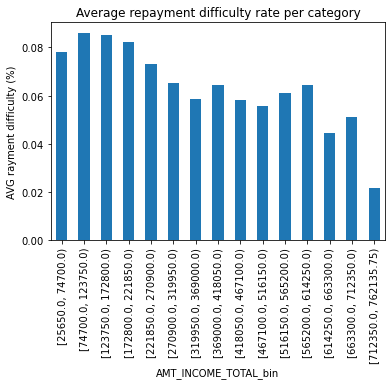

In [122]:
plot_bar_dv_unordered(payp_likelihood(variable))

Findings:
- No missing data
- Considering the non-normalised data, a log transformation will need to be applied for some algorithms
- Trend: the lower the customer's reported income, the better the repayment. I was expecting the opposite.
- Outliers need to be dealt with

**Feature:   AMT_CREDIT**

In [123]:
test_df = application_train_df.copy()

In [124]:
variable = 'AMT_CREDIT'

In [125]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

<AxesSubplot:title={'center':'AMT_CREDIT'}, xlabel='TARGET'>

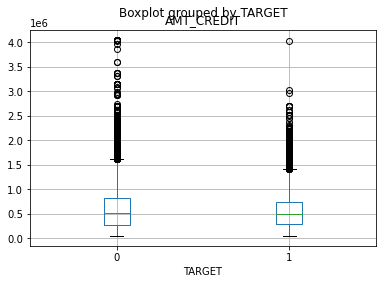

In [126]:
test_df.boxplot(column=variable, by='TARGET')

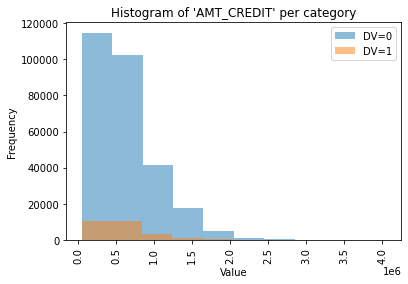

In [127]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable], test_df['TARGET'])

In [128]:
# Log transform the variable to normalise
test_df[variable + '_log'] = np.log(test_df[variable])

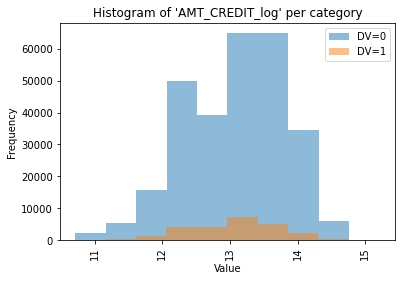

In [129]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable + '_log'], test_df['TARGET'])

In [130]:
# Remove outliers
test_df = test_df[(np.abs(stats.zscore(test_df[variable])) < 2.5)]

In [131]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(43441.83, 148878.0]",18022,1085,0.060204
"(148878.0, 252756.0]",41905,3199,0.076339
"(252756.0, 356634.0]",48555,4285,0.088250
"(356634.0, 460512.0]",30544,3095,0.101329
"(460512.0, 564390.0]",36163,3609,0.099798
"(564390.0, 668268.0]",19166,1993,0.103986
"(668268.0, 772146.0]",26966,2005,0.074353
"(772146.0, 876024.0]",19239,1485,0.077187
"(876024.0, 979902.0]",15412,1037,0.067285


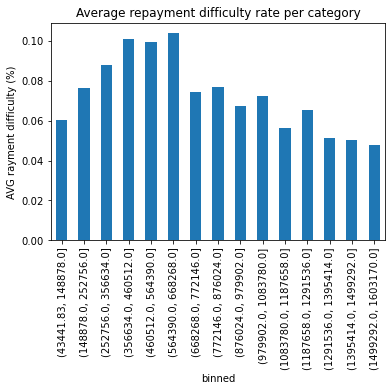

In [132]:
plot_bar_dv_unordered(payp_likelihood('binned'))

Findings:
- No missing data
- Interestingly, customers with a relatively low or high loan amount are less likely to experience payment difficulties
- Considering the non-normalised data, a log transformation will need to be applied for some algorithms
- Outliers need to be dealt with

**Feature:   AMT_ANNUITY**

In [133]:
test_df = application_train_df.copy()

In [134]:
variable = 'AMT_ANNUITY'

In [135]:
test_df[variable].describe()

count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64

In [136]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.003902299429939092

<AxesSubplot:title={'center':'AMT_ANNUITY'}, xlabel='TARGET'>

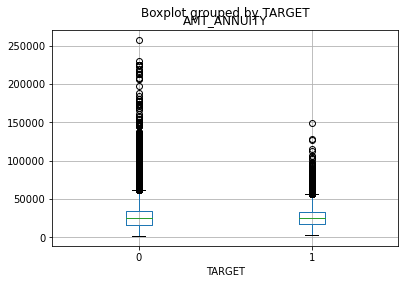

In [137]:
test_df.boxplot(column=variable, by='TARGET')

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


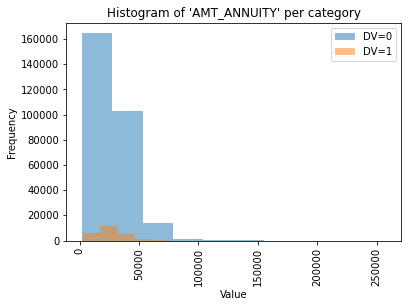

In [138]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable], test_df['TARGET'])

In [139]:
# Log transform the variable to normalise
test_df[variable + '_log'] = np.log(test_df[variable])

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


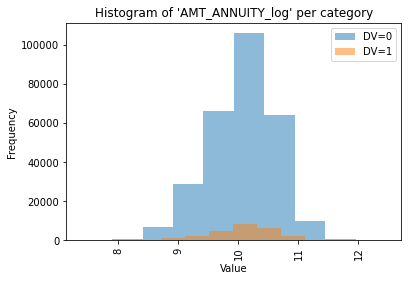

In [140]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable + '_log'], test_df['TARGET'])

In [141]:
# Remove outliers
q_min = test_df[variable].quantile(0.01)
q_max = test_df[variable].quantile(0.99)

test_df = test_df[(test_df[variable] < q_max) & (test_df[variable] > q_min)]

In [142]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(6119.194, 10436.7]",24258,1724,0.071069
"(10436.7, 14690.4]",34096,2367,0.069422
"(14690.4, 18944.1]",35828,3085,0.086106
"(18944.1, 23197.8]",40178,3514,0.087461
"(23197.8, 27451.5]",43110,3806,0.088286
"(27451.5, 31705.2]",33251,3258,0.097982
"(31705.2, 35958.9]",23966,2097,0.087499
"(35958.9, 40212.6]",20777,1631,0.078500
"(40212.6, 44466.3]",13422,1047,0.078006


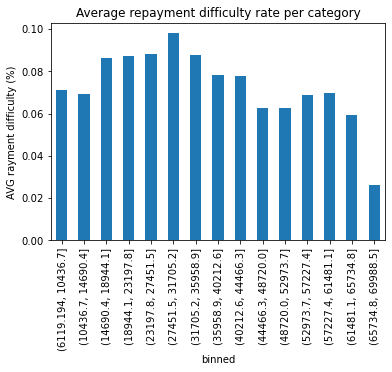

In [143]:
plot_bar_dv_unordered(payp_likelihood('binned'))

Findings:
- Small percentage of missing data (0.004)
- Customers with a smaller loan appear to be more likely to default
- Outliers need to be dealt with
- Considering the non-normalised data, a log transformation will need to be applied for some algorithms

**Feature:   AMT_GOODS_PRICE**

In [144]:
test_df = application_train_df.copy()

In [145]:
variable = 'AMT_GOODS_PRICE'

In [146]:
test_df[variable].describe()

count    3.072330e+05
mean     5.383962e+05
std      3.694465e+05
min      4.050000e+04
25%      2.385000e+05
50%      4.500000e+05
75%      6.795000e+05
max      4.050000e+06
Name: AMT_GOODS_PRICE, dtype: float64

In [147]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.09040327012692229

<AxesSubplot:title={'center':'AMT_GOODS_PRICE'}, xlabel='TARGET'>

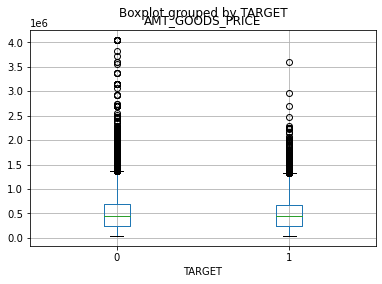

In [148]:
test_df.boxplot(column=variable, by='TARGET')

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


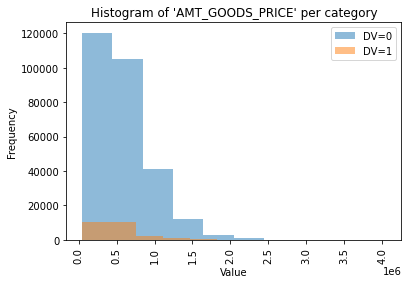

In [149]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable],
                  test_df['TARGET'])

In [150]:
# Log transform the variable to normalise
test_df[variable + '_log'] = np.log(test_df[variable])

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


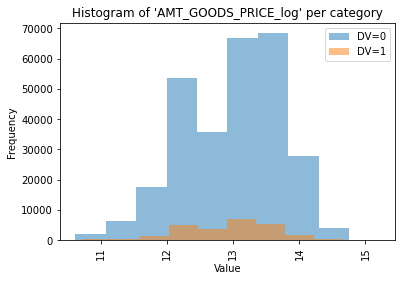

In [151]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable + '_log'], test_df['TARGET'])

In [152]:
# Remove outliers
q_min = test_df[variable].quantile(0.01)
q_max = test_df[variable].quantile(0.99)

test_df = test_df[(test_df[variable] < q_max) & (test_df[variable] > q_min)]

In [153]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(70276.5, 186900.0]",36280,2723,0.075055
"(186900.0, 301800.0]",65019,5467,0.084083
"(301800.0, 416700.0]",24530,2574,0.104933
"(416700.0, 531600.0]",55572,5717,0.102876
"(531600.0, 646500.0]",15251,1167,0.076520
"(646500.0, 761400.0]",40712,3118,0.076587
"(761400.0, 876300.0]",8110,578,0.071270
"(876300.0, 991200.0]",23919,1536,0.064217
"(991200.0, 1106100.0]",3846,241,0.062663


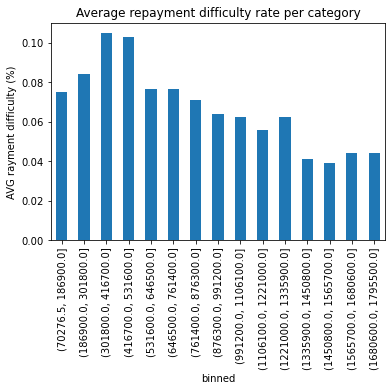

In [154]:
plot_bar_dv_unordered(payp_likelihood('binned'))

In [155]:
test_df[[variable, 'TARGET']].corr()

,AMT_GOODS_PRICE,TARGET
AMT_GOODS_PRICE,1.000000,-0.038037
TARGET,-0.038037,1.000000


Findings:
- Small percentage of missing data (0.09)
- The negative correlation shows that customers with a lower AMT goods price appear to be more likely to default. This makes sense, because customer 
- Outliers need to be dealt with in the data cleaning process
- As can be expected, repayment issues rate lowers as the goods price increases. This could have a negative impact on the financially excluded, considering that they are more likely to be able to purchase goods of lower prices. Repayment goes well for goods between the 301K-532K brackets, but drops from 761K

**Feature:   REGION_POPULATION_RELATIVE**

In [156]:
test_df = application_train_df.copy()

In [157]:
variable = 'REGION_POPULATION_RELATIVE'

In [158]:
test_df[variable].describe()

count    307511.000000
mean          0.020868
std           0.013831
min           0.000290
25%           0.010006
50%           0.018850
75%           0.028663
max           0.072508
Name: REGION_POPULATION_RELATIVE, dtype: float64

In [159]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

<AxesSubplot:title={'center':'REGION_POPULATION_RELATIVE'}, xlabel='TARGET'>

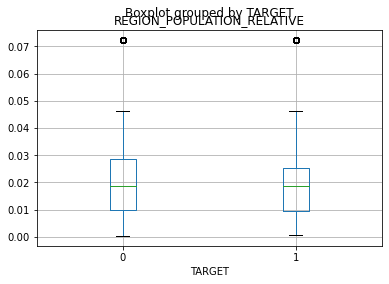

In [160]:
test_df.boxplot(column=variable, by='TARGET')

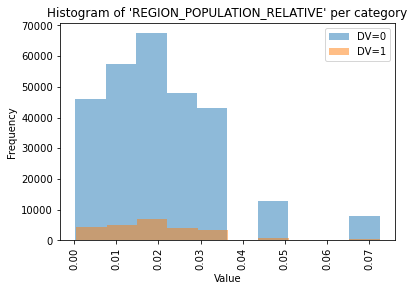

In [161]:
# Plot the distribution
plot_histogram_dv(test_df[variable], test_df['TARGET'])

In [162]:
# Remove outliers
q_min = test_df[variable].quantile(0.01)
q_max = test_df[variable].quantile(0.99)

test_df = test_df[(test_df[variable] < q_max) & (test_df[variable] > q_min)]

In [163]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(0.00246, 0.00542]",16402,1369,0.083465
"(0.00542, 0.00833]",35284,3153,0.089361
"(0.00833, 0.0112]",42645,3392,0.079540
"(0.0112, 0.0142]",6332,406,0.064119
"(0.0142, 0.0171]",19439,1688,0.086836
"(0.0171, 0.02]",47899,4329,0.090378
"(0.02, 0.0229]",25994,2539,0.097676
"(0.0229, 0.0258]",18354,1498,0.081617
"(0.0258, 0.0287]",22758,1659,0.072897


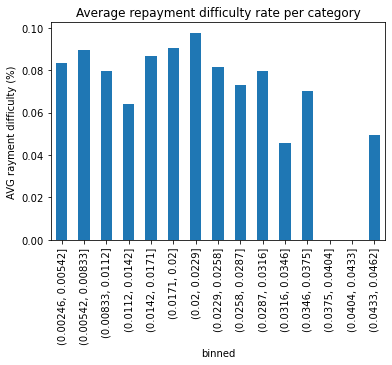

In [164]:
plot_bar_dv_unordered(payp_likelihood('binned'))

In [165]:
test_df[[variable, 'TARGET']].corr()

,REGION_POPULATION_RELATIVE,TARGET
REGION_POPULATION_RELATIVE,1.000000,-0.025564
TARGET,-0.025564,1.000000


Findings:
- No missing data
- Minimal outliers
- No clear trend or strong correlation can be identified, indicating that REGION_POPULATION_RELATIVE is unlikely a good preedictor feature

## Ordinal data

**Feature:   DAYS_REGISTRATION**

In [166]:
test_df = application_train_df.copy()

In [167]:
variable = 'DAYS_REGISTRATION'

In [168]:
test_df[variable].describe()

count    307511.000000
mean      -4986.120328
std        3522.886321
min      -24672.000000
25%       -7479.500000
50%       -4504.000000
75%       -2010.000000
max           0.000000
Name: DAYS_REGISTRATION, dtype: float64

In [169]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0

<AxesSubplot:title={'center':'DAYS_REGISTRATION'}, xlabel='TARGET'>

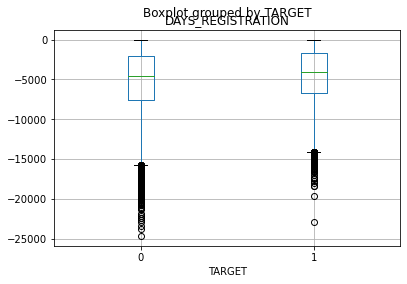

In [170]:
test_df.boxplot(column=variable, by='TARGET')

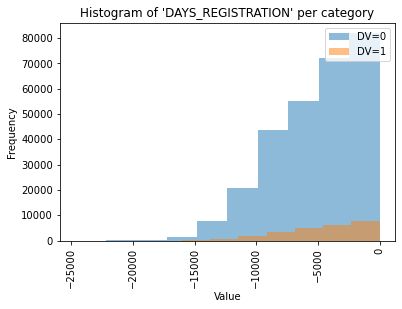

In [171]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable],
                  test_df['TARGET'])

In [172]:
# Make negative values positive in preparation of log transformation
# Remove zero values by adding 1
test_df[variable] = test_df[variable] * -1 + 1

In [173]:
# Log transform the variable to normalise
test_df[variable + '_log'] = np.log(test_df[variable])

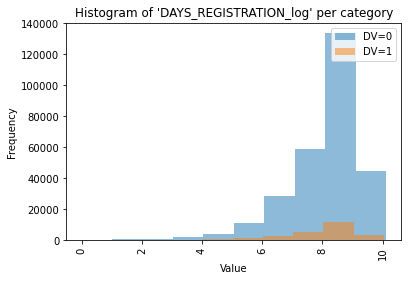

In [174]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable + '_log'], test_df['TARGET'])

In [175]:
# Remove outliers
q_min = test_df[variable].quantile(0.01)
q_max = test_df[variable].quantile(0.99)

test_df = test_df[(test_df[variable] < q_max) & (test_df[variable] > q_min)]

In [176]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(38.173, 973.8]",39618,3784,0.095512
"(973.8, 1895.6]",30971,2649,0.085532
"(1895.6, 2817.4]",27321,2422,0.088650
"(2817.4, 3739.2]",27717,2395,0.086409
"(3739.2, 4661.0]",30695,2666,0.086855
"(4661.0, 5582.8]",28184,2427,0.086113
"(5582.8, 6504.6]",21663,1686,0.077829
"(6504.6, 7426.4]",20258,1565,0.077253
"(7426.4, 8348.2]",18894,1328,0.070287


In [177]:
# Calculate repayment difficulties likelihood
payp_likelihood('binned').sort_values(ascending=False)

binned
(38.173, 973.8]       0.095512
(1895.6, 2817.4]      0.088650
(3739.2, 4661.0]      0.086855
(2817.4, 3739.2]      0.086409
(4661.0, 5582.8]      0.086113
(973.8, 1895.6]       0.085532
(5582.8, 6504.6]      0.077829
(6504.6, 7426.4]      0.077253
(7426.4, 8348.2]      0.070287
(8348.2, 9270.0]      0.069402
(12035.4, 12957.2]    0.059424
(9270.0, 10191.8]     0.059374
(10191.8, 11113.6]    0.057288
(11113.6, 12035.4]    0.057206
(12957.2, 13879.0]    0.050324
Name: TARGET, dtype: float64

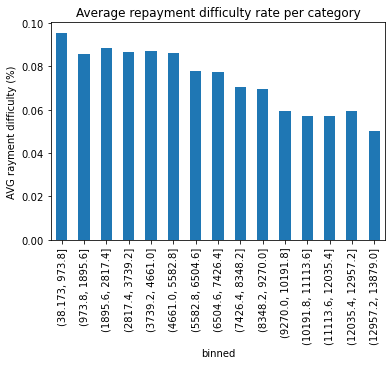

In [178]:
plot_bar_dv_unordered(payp_likelihood('binned'))

In [179]:
test_df[[variable, 'TARGET']].corr()

,DAYS_REGISTRATION,TARGET
DAYS_REGISTRATION,1.000000,-0.039661
TARGET,-0.039661,1.000000


Findings:
- No missing data
- Customers with a smaller AMT goods price appear to be more likely to default
- Outliers need to be dealt with. Because of negative values, needs to be transformed to positive to be able to apply IQR outlier removal
- Variable will need log transformation to allow modelling for some variables
- Trend: customers who register longer in advance are less  likely to experience payment difficulties

**Feature:   CNT_FAM_MEMBERS**

In [180]:
test_df = application_train_df.copy()

In [181]:
variable = 'CNT_FAM_MEMBERS'

In [182]:
test_df[variable].describe()

count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64

In [183]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.0006503832383231819

<AxesSubplot:title={'center':'CNT_FAM_MEMBERS'}, xlabel='TARGET'>

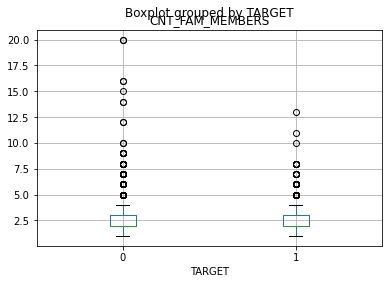

In [184]:
test_df.boxplot(column=variable, by='TARGET')

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


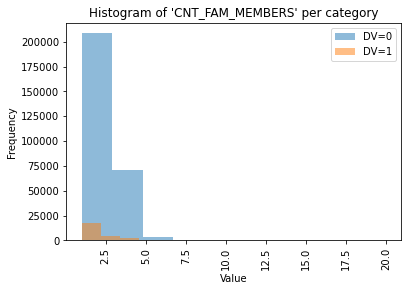

In [185]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable],
                  test_df['TARGET'])

In [186]:
# Remove outliers
q_min = test_df[variable].quantile(0.01)
q_max = test_df[variable].quantile(0.99)

test_df = test_df[(test_df[variable] < q_max) & (test_df[variable] > q_min)]

In [187]:
# Evaluate payment issues trend
test_df[[variable, 'SUM', 'TARGET']].groupby(variable).sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
CNT_FAM_MEMBERS,,,
2.0,158357,12009,0.075835
3.0,52601,4608,0.087603
4.0,24697,2136,0.086488


Findings:
- Minimal missing data
- Large amount of outliers
- Applicants with 2 family menbers appear to experience less payment issues, but this can be the result of limited data

**Feature:   DEF_30_CNT_SOCIAL_CIRCLE**

In [188]:
test_df = application_train_df.copy()

In [189]:
variable = 'DEF_30_CNT_SOCIAL_CIRCLE'

In [190]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.3320206431639844

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


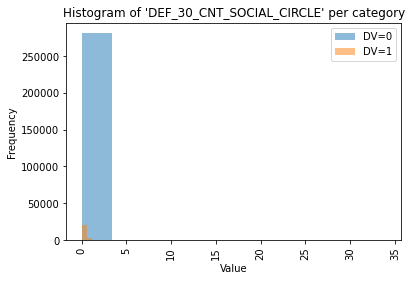

In [191]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable],
                  test_df['TARGET'])

<AxesSubplot:title={'center':'DEF_30_CNT_SOCIAL_CIRCLE'}, xlabel='TARGET'>

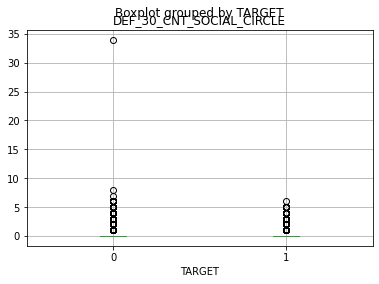

In [192]:
test_df.boxplot(column=variable, by='TARGET')

In [193]:
# Create feature bins to evaluate payment issues trend
test_df[variable] = pd.cut(x=test_df[variable], bins=15)
test_df[[variable, 'SUM', 'TARGET']].groupby(variable).sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
DEF_30_CNT_SOCIAL_CIRCLE,,,
"(-0.034, 2.267]",304975,24592,0.080636
"(2.267, 4.533]",1445,188,0.130104
"(4.533, 6.8]",67,9,0.134328
"(6.8, 9.067]",2,0,0.000000
"(9.067, 11.333]",0,0,NaN
"(11.333, 13.6]",0,0,NaN
"(13.6, 15.867]",0,0,NaN
"(15.867, 18.133]",0,0,NaN
"(18.133, 20.4]",0,0,NaN


In [194]:
# Calculate the % of customers with value 0
len(test_df[test_df[variable] == 0]) / len(test_df)

0.0

Findings:
- Small amount of missing data (0.33%)
- 24% has one observations of social surroundings defaulted 30 days past due
- The majority of applicants (88%) didn't fall withing this category
 - Large amount of outliers due to skewed data
- customers with 2.267 or less observations of social surroundings defaulted 30 days past due are almost half as likely to have payment issues

**Feature:  OBS_60_CNT_SOCIAL_CIRCLE**

In [195]:
test_df = application_train_df.copy()

In [196]:
variable = 'OBS_60_CNT_SOCIAL_CIRCLE'

In [197]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.3320206431639844

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


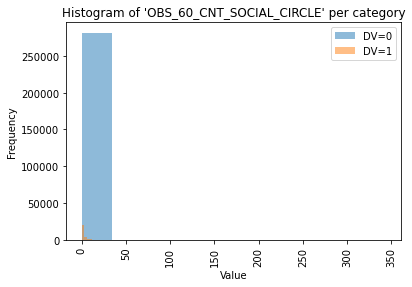

In [198]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable],
                  test_df['TARGET'])

In [199]:
test_df[variable].value_counts(normalize=True)

0.0      0.537264
1.0      0.159451
2.0      0.097119
3.0      0.065956
4.0      0.045502
5.0      0.030875
6.0      0.020715
7.0      0.014173
8.0      0.009416
9.0      0.006392
10.0     0.004356
11.0     0.002731
12.0     0.002023
13.0     0.001308
14.0     0.000777
15.0     0.000542
16.0     0.000447
17.0     0.000238
18.0     0.000160
19.0     0.000144
20.0     0.000098
21.0     0.000091
22.0     0.000065
23.0     0.000042
24.0     0.000039
25.0     0.000036
27.0     0.000016
29.0     0.000007
28.0     0.000003
344.0    0.000003
47.0     0.000003
26.0     0.000003
30.0     0.000003
Name: OBS_60_CNT_SOCIAL_CIRCLE, dtype: float64

<AxesSubplot:title={'center':'OBS_60_CNT_SOCIAL_CIRCLE'}, xlabel='TARGET'>

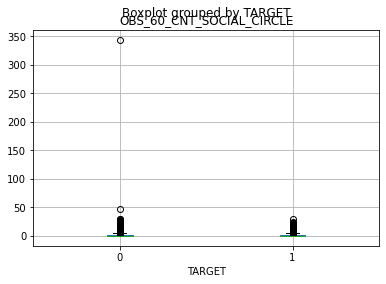

In [200]:
test_df.boxplot(column=variable, by='TARGET')

In [201]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(-0.344, 22.933]",306442,24785,0.080880
"(22.933, 45.867]",46,4,0.086957
"(45.867, 68.8]",1,0,0.000000
"(68.8, 91.733]",0,0,NaN
"(91.733, 114.667]",0,0,NaN
"(114.667, 137.6]",0,0,NaN
"(137.6, 160.533]",0,0,NaN
"(160.533, 183.467]",0,0,NaN
"(183.467, 206.4]",0,0,NaN


Findings
- Small amount of missing data (0.33%)
- Around 53% of applicants doesn't fall within this category


**Feature:   DAYS_LAST_PHONE_CHANGE**

In [202]:
test_df = application_train_df.copy()

In [203]:
variable = 'AMT_GOODS_PRICE'

In [204]:
# Calculate the % of missing data
test_df[variable].isna().sum() / test_df[variable].isna().count() * 100

0.09040327012692229

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


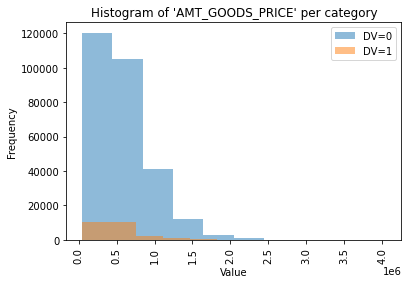

In [205]:
# Plot the distribution of contract types
plot_histogram_dv(test_df[variable],
                  test_df['TARGET'])

<AxesSubplot:title={'center':'AMT_GOODS_PRICE'}, xlabel='TARGET'>

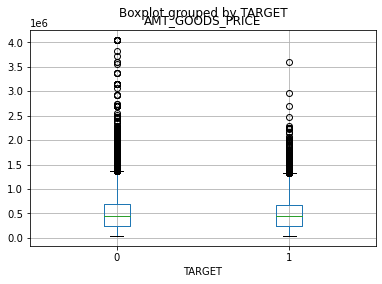

In [206]:
test_df.boxplot(column=variable, by='TARGET')

In [207]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=15)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(36490.5, 307800.0]",105297,8432,0.080078
"(307800.0, 575100.0]",86485,8730,0.100942
"(575100.0, 842400.0]",55191,4214,0.076353
"(842400.0, 1109700.0]",29950,1947,0.065008
"(1109700.0, 1377000.0]",22401,1162,0.051873
"(1377000.0, 1644300.0]",3736,159,0.042559
"(1644300.0, 1911600.0]",2889,119,0.041191
"(1911600.0, 2178900.0]",373,19,0.050938
"(2178900.0, 2446200.0]",846,18,0.021277


In [208]:
test_df[[variable, 'TARGET']].corr()

,AMT_GOODS_PRICE,TARGET
AMT_GOODS_PRICE,1.000000,-0.039645
TARGET,-0.039645,1.000000


Findings:
- 9% missing data
- Weak correlation with explanatory variable, indicating that this is unlikely a strong predictive feature

## Outlier removal

In [209]:
application_train_df.shape

(307511, 114)

### Continuous  features

In [210]:
test_df = application_train_df.copy()

<AxesSubplot:title={'center':'AMT_GOODS_PRICE'}, xlabel='TARGET'>

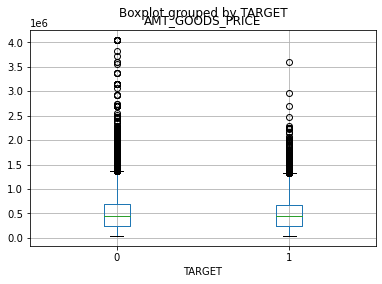

In [211]:
# Plot Credit amount request before outlier removal
test_df.boxplot(column=variable, by='TARGET')

In [212]:
test_df['AMT_CREDIT'].describe()

count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

In [213]:
# Transform values DAYS_REGISTRATION from negative to positive in order to be able to apply IQR method
test_df['DAYS_REGISTRATION'] = test_df['DAYS_REGISTRATION'] * -1

In [214]:
# Remove outliers in continuous features using IQR
column_selection = list(test_df.select_dtypes(include=['float64']))

dataframe = test_df
rows_remove = []

for column in column_selection:
    IQR_sorted = sorted(dataframe[column])
    IQR = dataframe[column].median()
    Q1 = np.percentile(IQR_sorted, [25])
    Q3 = np.percentile(IQR_sorted, [75])
    lower_bound = (Q1 - (1.6 * IQR)).item()
    upper_bound = (Q3 + (1.6 * IQR)).item()
    rows = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)].index.tolist()
    rows_remove = rows_remove + rows

print("Outliers dropped:", (len(rows_remove) / len(dataframe.index)) * 100, '%')

# Drop outlier customers from dataframe
test_df = dataframe.loc[~dataframe.index.isin(rows_remove)]

Outliers dropped: 7.214050879480734 %


<AxesSubplot:title={'center':'AMT_CREDIT'}, xlabel='TARGET'>

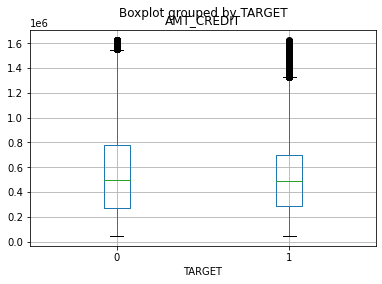

In [215]:
# Plot Credit amount request after outlier removal
test_df.boxplot(column='AMT_CREDIT', by='TARGET')

In [216]:
test_df['AMT_CREDIT'].describe()

count    2.878140e+05
mean     5.621675e+05
std      3.491464e+05
min      4.500000e+04
25%      2.700000e+05
50%      4.975200e+05
75%      7.819200e+05
max      1.629418e+06
Name: AMT_CREDIT, dtype: float64

The before and after boxplots visualise the reduced spread of the variable, which helps to generalise the final ML model and make it applicable to a larger customer base. 

### Categorical features

Besides the continuous features, the categorical features have a large spread of values. Reducing the spread will allow for better model performance.

In [217]:
test_df = application_train_df.copy()

In [218]:
# Create a count of unique values per categorical feature
cat_features = list(test_df.select_dtypes(include=['O']))
test_df[cat_features].nunique().sort_values(ascending=False)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                7
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_REALTY                2
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
dtype: int64

Based on the above list, it is clear that the feature 'ORGANIZATION_TYPE' requires some feature engineering to adjust the spread in the feature values.

In [219]:
test_df['ORGANIZATION_TYPE'].value_counts(normalize=True)

Business Entity Type 3    0.221104
XNA                       0.180072
Self-employed             0.124913
Other                     0.054252
Medicine                  0.036399
Business Entity Type 2    0.034317
Government                0.033833
School                    0.028919
Trade: type 7             0.025466
Kindergarten              0.022373
Construction              0.021856
Business Entity Type 1    0.019459
Transport: type 4         0.017554
Trade: type 3             0.011356
Industry: type 9          0.010952
Industry: type 3          0.010660
Security                  0.010559
Housing                   0.009619
Industry: type 11         0.008793
Military                  0.008566
Bank                      0.008153
Agriculture               0.007980
Police                    0.007613
Transport: type 2         0.007167
Postal                    0.007014
Security Ministries       0.006419
Trade: type 2             0.006179
Restaurant                0.005889
Services            

In [220]:
# Count of unique values of column ORGANIZATION_TYPE
test_df['ORGANIZATION_TYPE'].nunique()

58

<AxesSubplot:>

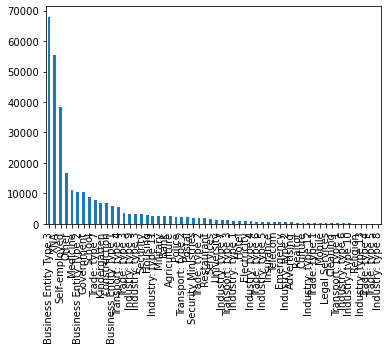

In [221]:
# Visualise the wide array of unique values before outlier removal
test_df['ORGANIZATION_TYPE'].value_counts().plot(kind='bar')

In [222]:
test_df['ORGANIZATION_TYPE'].value_counts(normalize=True)

Business Entity Type 3    0.221104
XNA                       0.180072
Self-employed             0.124913
Other                     0.054252
Medicine                  0.036399
Business Entity Type 2    0.034317
Government                0.033833
School                    0.028919
Trade: type 7             0.025466
Kindergarten              0.022373
Construction              0.021856
Business Entity Type 1    0.019459
Transport: type 4         0.017554
Trade: type 3             0.011356
Industry: type 9          0.010952
Industry: type 3          0.010660
Security                  0.010559
Housing                   0.009619
Industry: type 11         0.008793
Military                  0.008566
Bank                      0.008153
Agriculture               0.007980
Police                    0.007613
Transport: type 2         0.007167
Postal                    0.007014
Security Ministries       0.006419
Trade: type 2             0.006179
Restaurant                0.005889
Services            

While reviewing the long list of values, some values overlap that can be used to group customers with similar values. For instance 'Business Entity Type 3' and 'Business Entity Type 2' can be grouped under the overarching group of 'Business'.

In [223]:
test_df['ORGANIZATION_TYPE_recode'] = test_df['ORGANIZATION_TYPE']

In [224]:
test_df = application_train_df.copy()

In [225]:
# Recode organisation subcategories into one main category (eg 'Trade: type 6 -> 'Trade)
dataframe = test_df
column = dataframe['ORGANIZATION_TYPE']
types = ['Trade', 'Industry', 'Transport', 'Business']

for item in types:
    column.loc[column.str.startswith(item, na=False)] = item

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [226]:
# select values with a low frequency and replace with "other"
dataframe = test_df
threshold = 0.01
column_selection = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'ORGANIZATION_TYPE']

for col in dataframe[column_selection]:
    count = dataframe[col].value_counts(normalize=True)
    to_replace = count[count <= threshold].index.tolist()
    dataframe[col].replace(to_replace=to_replace, value="Other2", inplace=True)

In [227]:
application_train_df['ORGANIZATION_TYPE'].nunique()

58

In [228]:
test_df['ORGANIZATION_TYPE'].nunique()

14

By applying this recode we've been able to regroup some of the customer organisation type and reduce the variability of the features values from 58 to 14. This should improve the model performance as more customers are allocated to a specific category instead of allocated the "other" category in the next step.

<AxesSubplot:>

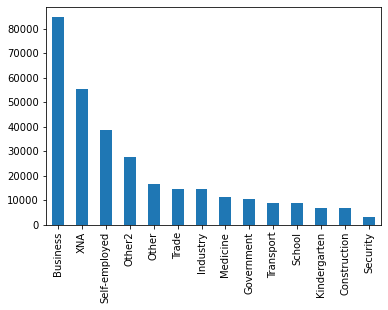

In [229]:
# Show unique values example feature after outlier removal
test_df['ORGANIZATION_TYPE'].value_counts().plot(kind='bar')

In [230]:
# Create a count of unique values per categorical feature
cat_features = list(test_df.select_dtypes(include=['O']))
test_df[cat_features].nunique().sort_values(ascending=False)

OCCUPATION_TYPE               18
ORGANIZATION_TYPE             14
WALLSMATERIAL_MODE             7
WEEKDAY_APPR_PROCESS_START     7
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
NAME_EDUCATION_TYPE            5
NAME_INCOME_TYPE               5
NAME_TYPE_SUITE                5
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
CODE_GENDER                    3
EMERGENCYSTATE_MODE            2
FLAG_OWN_REALTY                2
FLAG_OWN_CAR                   2
NAME_CONTRACT_TYPE             2
dtype: int64

   ## Feature engineering

Key features according to the following research paper on mortgage default risk:
- loan-to-value = the ratio of a loan to the value of an asset purchased
- crises. The literature review says that its rare for a home owner to default their mortgage, but that it is more likely during a crisis of some sort (e.g. recession). Having date of application would enable us to create a feature for this, which is a datapoint that usually is always included in a business setting

No strong correlations but worth evaluating:
- debt-to-income

https://poseidon01.ssrn.com/delivery.php?ID=093116088071089127066083066089099089001069066016061000078109018044108023027000114096034091044008086039047056107022028007073008035007001028117125006106116091031074074088027070123005104113001068097107004028017126066&EXT=pdf

### Feature loan % total income

In [231]:
test_df = application_train_df.copy()

In [232]:
variable = 'creditVSincome'

In [233]:
test_df[variable] = test_df['AMT_CREDIT'] / test_df['AMT_INCOME_TOTAL']

<AxesSubplot:title={'center':'creditVSincome'}, xlabel='TARGET'>

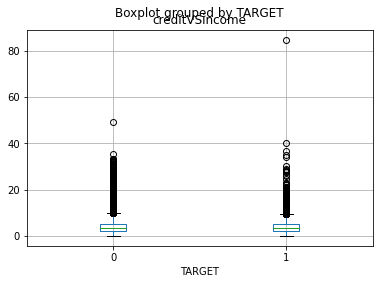

In [234]:
test_df.boxplot(column=variable, by='TARGET')

In [235]:
# Create key stats of the new variable, distinguishing between explanatory variable
test_df[test_df['TARGET'] == 1][variable].describe()

count    24825.000000
mean         3.887438
std          2.627348
min          0.004808
25%          2.130435
50%          3.253143
75%          4.991667
max         84.736842
Name: creditVSincome, dtype: float64

In [236]:
# Create key stats of the new variable, distinguishing between explanatory variable
test_df[test_df['TARGET'] == 0][variable].describe()

count    282686.000000
mean          3.963729
std           2.695055
min           0.037500
25%           2.000333
50%           3.266653
75%           5.191333
max          49.227200
Name: creditVSincome, dtype: float64

In [237]:
# Create feature bins to evaluate payment issues trend
test_df['binned'] = pd.cut(x=test_df[variable], bins=20)
test_df[['binned', 'SUM', 'TARGET']].groupby('binned').sum().eval('Payment_issues_rate = TARGET / SUM')

,SUM,TARGET,Payment_issues_rate
binned,,,
"(-0.0799, 4.241]",198639,16531,0.083221
"(4.241, 8.478]",89013,6930,0.077854
"(8.478, 12.715]",16480,1134,0.068811
"(12.715, 16.951]",2714,179,0.065954
"(16.951, 21.188]",481,31,0.064449
"(21.188, 25.424]",123,7,0.056911
"(25.424, 29.661]",35,7,0.200000
"(29.661, 33.898]",19,1,0.052632
"(33.898, 38.134]",4,3,0.750000


In [238]:
# calculate the correlation of the new features with the explanatory variable
test_df[[variable, 'TARGET']].corr()

,creditVSincome,TARGET
creditVSincome,1.000000,-0.007727
TARGET,-0.007727,1.000000


Findings:
- Interestingly, the payment issue rate appears to increase when the loan amount as % of income increases. I would have expected otherwise. However, this correlation is weak.
- Based on the above visualisation, key stats and correlation, this new feature will unlikely be a strong feature when creating our model. I will create this feature as part of the data cleaning process for completion, but it will likely be removed during the feature selection process.

# Next

Now we have an understanding of the dataset, the next step is to clean the data in preparation of the model creation. See the Data Cleaning notebook for this.